In [1]:
# Librerías a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from warnings import simplefilter

# Desactivar mensajes de advertencia innecesarios
simplefilter(action = "ignore", category = FutureWarning)

# Cargar datos en dataframe
# acciones
url_data = 'https://drive.google.com/file/d/1zsyz95Wylaebf7KN9trfrjxuXNkJUKTK/view?usp=sharing'
url_data = 'https://drive.google.com/uc?id=' + url_data.split('/')[-2]
df = pd.read_csv(url_data, sep = ";")

# Se reordenan las columnas para facilitar la lectura.
df = df[['emisor', 'fecha', 'valor','valor_nominal_usd','precio_usd','numero_acciones','valor_efectivo_usd','procedencia']]

# Mostrar los primeros registros
df.head()

,emisor,fecha,valor,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,procedencia
0,CERVECERIA NACIONAL CN S A,03/01/2023,ACCIONES,1.0,55.0,102,5610.0,G
1,CERVECERIA NACIONAL CN S A,03/01/2023,ACCIONES,1.0,55.0,10,550.0,Q
2,MUTUALISTA PICHINCHA,03/01/2023,CERTIFICADOS DE APORTACION,100.0,98.0,1,98.0,Q
3,MUTUALISTA PICHINCHA,03/01/2023,CERTIFICADOS DE APORTACION,100.0,98.0,1,98.0,Q
4,MUTUALISTA PICHINCHA,03/01/2023,CERTIFICADOS DE APORTACION,100.0,98.0,1,98.0,Q


In [2]:
# Cambiar el tipo de datos para poder separar año y mes en la fecha.
df["fecha"] = pd.to_datetime(df["fecha"], format='%d/%m/%Y')

# Se separa año y mes del campo de fecha
df["anio"] = df["fecha"].dt.year
df["mes"] = df["fecha"].dt.month

# Se quitan espacios en blanco al inicio y al final del campo de texto.
df["emisor"] = df["emisor"].str.strip()
df["valor"] = df["valor"].str.strip()

# Se calcula la relación de precio de acciones entre el original y el nuevo.
df["porcentaje_precio"] = df["precio_usd"] / df["valor_nominal_usd"] * 100

# Se eliminan la columna de fecha original, por cuanto ya no se van a usar.
df = df.drop(["fecha"], axis = 1)

# El algoritmo K-means trabaja con números, por lo que se aplica la codificación one hot encoder para convertir los valores categóticos en columnas binarias, con valores 1 o 0.

# Listar las columnas categóricas.
categorical_cols = ['valor', 'procedencia']

df = pd.get_dummies(df, columns = categorical_cols)
df

,emisor,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q
0,CERVECERIA NACIONAL CN S A,1.0,55.00,102,5610.00,2023,1,5500.0,1,0,0,1,0
1,CERVECERIA NACIONAL CN S A,1.0,55.00,10,550.00,2023,1,5500.0,1,0,0,0,1
2,MUTUALISTA PICHINCHA,100.0,98.00,1,98.00,2023,1,98.0,0,0,1,0,1
3,MUTUALISTA PICHINCHA,100.0,98.00,1,98.00,2023,1,98.0,0,0,1,0,1
4,MUTUALISTA PICHINCHA,100.0,98.00,1,98.00,2023,1,98.0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11600,CORPORACION FAVORITA C.A.,1.0,2.16,695,1501.20,2022,12,216.0,1,0,0,0,1
11601,BANCO GUAYAQUIL S.A.,1.0,1.10,7195,7914.50,2022,12,110.0,1,0,0,0,1
11602,BANCO DE LA PRODUCCION S.A . PRODUBANCO,1.0,0.78,1115,869.70,2022,12,78.0,1,0,0,0,1
11603,CORPORACION FAVORITA C.A.,1.0,2.15,2000,4300.00,2022,12,215.0,1,0,0,0,1


In [3]:
# Crear un nuevo dataframe sin el listado de emisores
df_ftr = df.drop(["emisor"], axis = 1)

# Mostrar los primeros registros
df_ftr.head()

,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q
0,1.0,55.0,102,5610.0,2023,1,5500.0,1,0,0,1,0
1,1.0,55.0,10,550.0,2023,1,5500.0,1,0,0,0,1
2,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1
3,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1
4,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1


In [4]:
# Descripción del dataframe
df_ftr.describe()

,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q
count,11605.000000,11605.000000,1.160500e+04,1.160500e+04,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000
mean,57.631538,59.390570,3.034630e+03,5.398222e+03,2022.324257,5.573546,347.193844,0.510987,0.003619,0.485394,0.126497,0.873503
std,119.508804,114.978476,3.041211e+04,4.846019e+04,0.468117,3.326360,999.568117,0.499901,0.060053,0.499808,0.332423,0.332423
min,1.000000,0.300000,1.000000e+00,1.010000e+00,2022.000000,1.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.140000,1.000000e+00,1.000000e+02,2022.000000,3.000000,100.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,100.000000,77.000000,1.000000e+01,2.000000e+02,2022.000000,5.000000,100.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,100.000000,100.000000,1.200000e+03,2.915000e+03,2023.000000,8.000000,214.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,2500.000000,2700.000000,2.000000e+06,4.178633e+06,2023.000000,12.000000,6400.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Realizar el escalado de datos para que las columnas estén en un rango de 0 y 1
# Las columnas que fueron convertidas a one hot no se ven afectadas por esta operación porque ya están entre 0 y 1.
df_sc = (df_ftr - df_ftr.min()) / (df_ftr.max() - df_ftr.min())

# Confirmar que los valores estén entre 0 y 1
df_sc.describe()

,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q
count,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000,11605.000000
mean,0.022662,0.021888,0.001517,0.001292,0.324257,0.415777,0.049795,0.510987,0.003619,0.485394,0.126497,0.873503
std,0.047823,0.042589,0.015206,0.011597,0.468117,0.302396,0.156918,0.499901,0.060053,0.499808,0.332423,0.332423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000682,0.000000,0.000024,0.000000,0.181818,0.010989,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.039616,0.028411,0.000005,0.000048,0.000000,0.363636,0.010989,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.039616,0.036930,0.000600,0.000697,1.000000,0.636364,0.028885,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


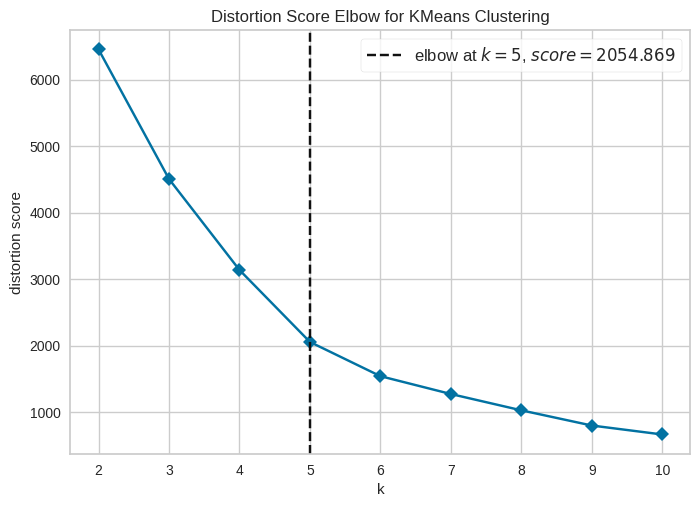

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# Utilizar el "elbow method" para calcular el número óptimo de clústeres.
# Parámetros:
# model: el modelo que se va a avaluar, en este caso KMeans
# k: el rango de clústeres que se van a probar, en este caso, de 1 a 10. Se coloca 11 porque en la sintaxis ese valor no está incluido.
# timings: Se coloca False para que no se muestre una línea con los tiempos de entrenamiento para cada iteración. No es relevante y de esa manera se aprecia mejor el gráfico.
# metric: la métrica por defecto es distortion, sin embargo hay otras opciones como silhouette y calinski_harabasz.

# Usando la métrica distortion:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(10), metric='distortion', timings=False)
visualizer.fit(df_sc)
visualizer.show()

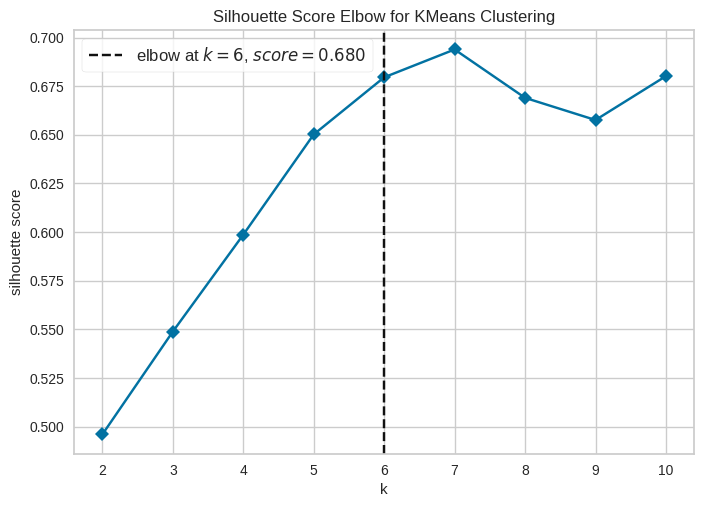

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [7]:
# Usando la métrica silhouette:
visualizer = KElbowVisualizer(model, k=(10), metric='silhouette', timings=False)
visualizer.fit(df_sc)
visualizer.show()

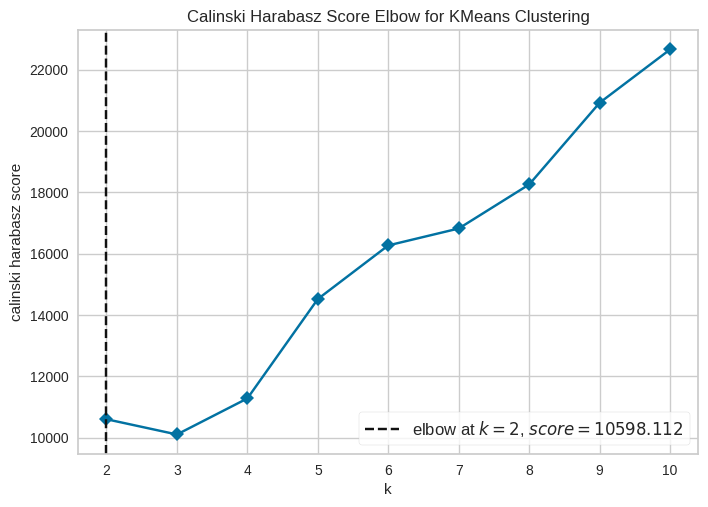

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [8]:
# Usando la métrica calinski_harabasz:
visualizer = KElbowVisualizer(model, k=(10), metric='calinski_harabasz', timings=False)
visualizer.fit(df_sc)
visualizer.show()

In [9]:
# No todas las métricas son apropiadas para el mismo set de datos. En este caso se escoge el distortion que es la medida por defecto, el cual sugiere 5 clústeres.

# Aplicar el algoritmo K-means
# Parámetros:
# n_clusters: El número de clústeres en que se vana dividir los datos, el cual fue calculado previamente.
# init: selecciona los centroides iniciales de cada clúster utilizando un mustreo que se base en una distribución probable empírica de los puntos. Se utiliza k-means++.
# random_state: Los registros se procesan aleatoriamente. Para facilitar el seguimiento, se usa un número entero, ejemplo el 42, para que en cada ejecución se mantenga este orden.

kmeans_model = KMeans(n_clusters = 5, init = "k-means++", random_state = 42)
kmeans_model.fit(df_sc)

# Crear un nuevo dataset con los datos del original más una nueva columna con el número de clúster que se le asignó a la instancia.
df_c = df
df_c["cluster"] = kmeans_model.labels_
df_sc_c = df_sc
df_sc_c["cluster"] = kmeans_model.labels_
df_c.head()

,emisor,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q,cluster
0,CERVECERIA NACIONAL CN S A,1.0,55.0,102,5610.0,2023,1,5500.0,1,0,0,1,0,3
1,CERVECERIA NACIONAL CN S A,1.0,55.0,10,550.0,2023,1,5500.0,1,0,0,0,1,2
2,MUTUALISTA PICHINCHA,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1,4
3,MUTUALISTA PICHINCHA,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1,4
4,MUTUALISTA PICHINCHA,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1,4


In [10]:
# Observar la cantidad de instancias asignadas a cada clúster.
df_c.groupby(["cluster"])["cluster"].count()

cluster
0    3378
1    3494
2    1413
3    1468
4    1852
Name: cluster, dtype: int64

In [11]:
# Verificar el promedo del silhouette score para comprobar qué tan buena fue la clasificación en los clústeres. Un valor cercano a 1 es mejor.
silhouette_score_mean = silhouette_score(df_sc_c, df_sc_c["cluster"])
print(silhouette_score_mean)

0.7754531238155696


In [12]:
# Aplicar PCA (Análisis de componentes principales) para facilitar una representación gráfica en dos dimensiones.
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca_df_sc_c = pca.fit_transform(df_sc)
pca_df_sc_c = pd.DataFrame(data = pca_df_sc_c, columns = ["Variable_1", "Variable_2"])
pca_df_sc_c = pd.concat([pca_df_sc_c, df_sc_c[["cluster"]]], axis = 1)

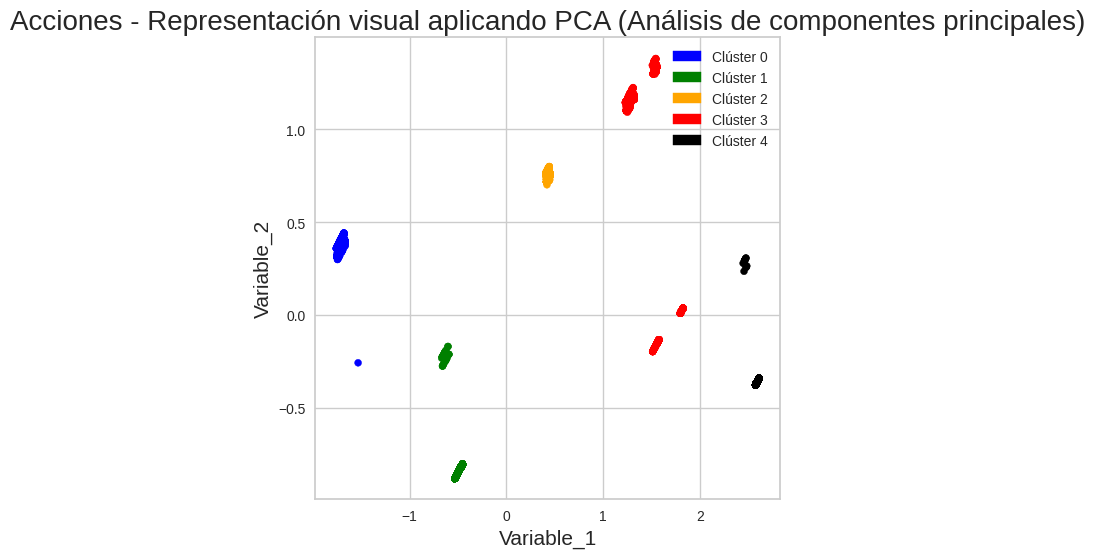

In [13]:
# Realizar gráfico, dándole un color diferente a cada clúster para mejor apreciación.
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Variable_1", fontsize = 15)
ax.set_ylabel("Variable_2", fontsize = 15)
ax.set_title("Acciones - Representación visual aplicando PCA (Análisis de componentes principales)", fontsize = 20)
color = np.array(["blue", "green", "orange", "red", "black"])
ax.scatter(x = pca_df_sc_c.Variable_1, y = pca_df_sc_c.Variable_2, c = color[pca_df_sc_c.cluster], s = 25)

# Crear etiquetas de la leyenda.
azul = mpatches.Patch(color = "blue", label = "Clúster 0")
verde = mpatches.Patch(color = "green", label = "Clúster 1")
naranja = mpatches.Patch(color = "orange", label = "Clúster 2")
rojo = mpatches.Patch(color = "red", label = "Clúster 3")
negro = mpatches.Patch(color = "black", label = "Clúster 4")

# Colocar la leyenda.
plt.legend(handles = [azul, verde, naranja, rojo, negro])

plt.show()

In [14]:
# Consultar los miembros de cada clúster
df[df.cluster == 0]

,emisor,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q,cluster
3763,BANCO GUAYAQUIL S.A.,1.0,0.99,3500,3465.00,2022,1,99.0,1,0,0,0,1,0
3764,BANCO DE LA PRODUCCION S.A . PRODUBANCO,1.0,0.65,8678,5640.70,2022,1,65.0,1,0,0,0,1,0
3765,BANCO GUAYAQUIL S.A.,1.0,0.99,30000,29700.00,2022,1,99.0,1,0,0,0,1,0
3766,BANCO DE LA PRODUCCION S.A . PRODUBANCO,1.0,0.70,14000,9800.00,2022,1,70.0,1,0,0,0,1,0
3768,BANCO DE LA PRODUCCION S.A . PRODUBANCO,1.0,0.70,1000,700.00,2022,1,70.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11599,CORPORACION FAVORITA C.A.,1.0,2.15,2315,4977.25,2022,12,215.0,1,0,0,0,1,0
11600,CORPORACION FAVORITA C.A.,1.0,2.16,695,1501.20,2022,12,216.0,1,0,0,0,1,0
11601,BANCO GUAYAQUIL S.A.,1.0,1.10,7195,7914.50,2022,12,110.0,1,0,0,0,1,0
11602,BANCO DE LA PRODUCCION S.A . PRODUBANCO,1.0,0.78,1115,869.70,2022,12,78.0,1,0,0,0,1,0


In [15]:
df[df.cluster == 1]

,emisor,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q,cluster
3771,MUTUALISTA PICHINCHA,100.0,100.0,1,100.0,2022,1,100.0,0,0,1,0,1,1
3772,MUTUALISTA PICHINCHA,100.0,100.0,1,100.0,2022,1,100.0,0,0,1,0,1,1
3773,MUTUALISTA PICHINCHA,100.0,100.0,1,100.0,2022,1,100.0,0,0,1,0,1,1
3774,MUTUALISTA PICHINCHA,100.0,100.0,1,100.0,2022,1,100.0,0,0,1,0,1,1
3775,MUTUALISTA PICHINCHA,100.0,100.0,1,100.0,2022,1,100.0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11580,MUTUALISTA PICHINCHA,100.0,98.5,1,98.5,2022,12,98.5,0,0,1,0,1,1
11581,MUTUALISTA PICHINCHA,100.0,98.5,1,98.5,2022,12,98.5,0,0,1,0,1,1
11582,MUTUALISTA PICHINCHA,100.0,98.5,1,98.5,2022,12,98.5,0,0,1,0,1,1
11583,MUTUALISTA PICHINCHA,100.0,98.5,1,98.5,2022,12,98.5,0,0,1,0,1,1


In [16]:
df[df.cluster == 2]

,emisor,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q,cluster
1,CERVECERIA NACIONAL CN S A,1.0,55.00,10,550.0,2023,1,5500.000000,1,0,0,0,1,2
25,BANCO GUAYAQUIL S.A.,1.0,1.05,2000,2100.0,2023,1,105.000000,1,0,0,0,1,2
31,BANCO GUAYAQUIL S.A.,1.0,1.06,100,106.0,2023,1,106.000000,1,0,0,0,1,2
32,CORPORACION FAVORITA C.A.,1.0,2.15,30000,64500.0,2023,1,215.000000,1,0,0,0,1,2
33,CORPORACION FAVORITA C.A.,1.0,2.15,20000,43000.0,2023,1,215.000000,1,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3743,CORPORACION FAVORITA C.A.,1.0,2.05,98,200.9,2023,6,205.000000,1,0,0,0,1,2
3744,BANCO GUAYAQUIL S.A.,1.0,0.90,33256,29930.4,2023,6,90.000000,1,0,0,0,1,2
3745,CORPORACION FAVORITA C.A.,1.0,1.85,1000,1850.0,2023,6,185.000000,1,0,0,0,1,2
3746,HOLCIM ECUADOR S.A.,3.0,55.00,18,990.0,2023,6,1833.333333,1,0,0,0,1,2


In [17]:
df[df.cluster == 3]

,emisor,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q,cluster
0,CERVECERIA NACIONAL CN S A,1.0,55.00,102,5610.00,2023,1,5500.0,1,0,0,1,0,3
26,CORPORACION FAVORITA C.A.,1.0,2.15,912,1960.80,2023,1,215.0,1,0,0,1,0,3
27,BANCO GUAYAQUIL S.A.,1.0,1.05,300,315.00,2023,1,105.0,1,0,0,1,0,3
28,BANCO GUAYAQUIL S.A.,1.0,1.05,2200,2310.00,2023,1,105.0,1,0,0,1,0,3
29,CORPORACION FAVORITA C.A.,1.0,2.15,450,967.50,2023,1,215.0,1,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11464,CERVECERIA NACIONAL CN S A,1.0,55.00,51,2805.00,2022,12,5500.0,1,0,0,1,0,3
11482,TECAFORTUNA SA,1.0,3.16,1580,4992.80,2022,12,316.0,1,0,0,1,0,3
11586,LA RESERVA FORESTAL S.A.(REFOREST),1.0,32.73,321,10506.33,2022,12,3273.0,1,0,0,1,0,3
11589,CERVECERIA NACIONAL CN S A,1.0,55.99,69,3863.31,2022,12,5599.0,1,0,0,1,0,3


In [18]:
df[df.cluster == 4]

,emisor,valor_nominal_usd,precio_usd,numero_acciones,valor_efectivo_usd,anio,mes,porcentaje_precio,valor_ACCIONES,valor_ACCIONES PREFERIDAS,valor_CERTIFICADOS DE APORTACION,procedencia_G,procedencia_Q,cluster
2,MUTUALISTA PICHINCHA,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1,4
3,MUTUALISTA PICHINCHA,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1,4
4,MUTUALISTA PICHINCHA,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1,4
5,MUTUALISTA PICHINCHA,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1,4
6,MUTUALISTA PICHINCHA,100.0,98.0,1,98.0,2023,1,98.0,0,0,1,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3756,MUTUALISTA PICHINCHA,100.0,100.0,1,100.0,2023,6,100.0,0,0,1,0,1,4
3757,MUTUALISTA PICHINCHA,100.0,100.0,1,100.0,2023,6,100.0,0,0,1,0,1,4
3758,MUTUALISTA PICHINCHA,100.0,100.0,1,100.0,2023,6,100.0,0,0,1,0,1,4
3759,MUTUALISTA PICHINCHA,100.0,100.0,2,200.0,2023,6,100.0,0,0,1,0,1,4


In [19]:
# Para analizar con mayor detalle cada clúster, se aplica SHAP. Este método no funciona directamente con el algoritmo K-means, sin embargo se puede aplicar una solución
# alterna aplicando un modelo de clasificación cuyas salidas correspondan a etiquetas que representan cada clúster.
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

y = kmeans_model.labels_
clf = RandomForestClassifier()
clf.fit(df_ftr, y)

RandomForestClassifier()

In [20]:
# Se instala la librería shap
!pip install shap

In [21]:
# Ahora que están hecho el preparativo, se ejecuta shap.

import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(df_ftr)

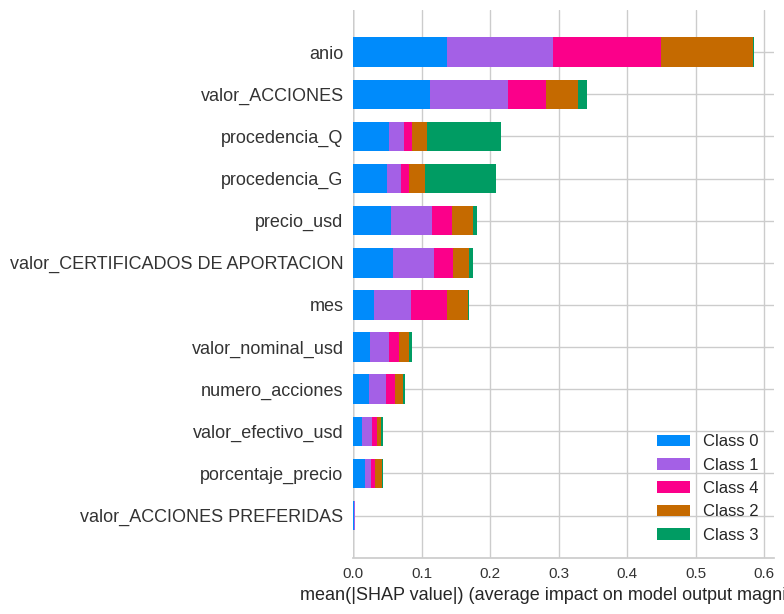

In [22]:
# Se representan gráficamente las características que más incidencia tienen al momento de realizar el agrupamiento en clústeres.
shap.summary_plot(shap_values, df_ftr)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


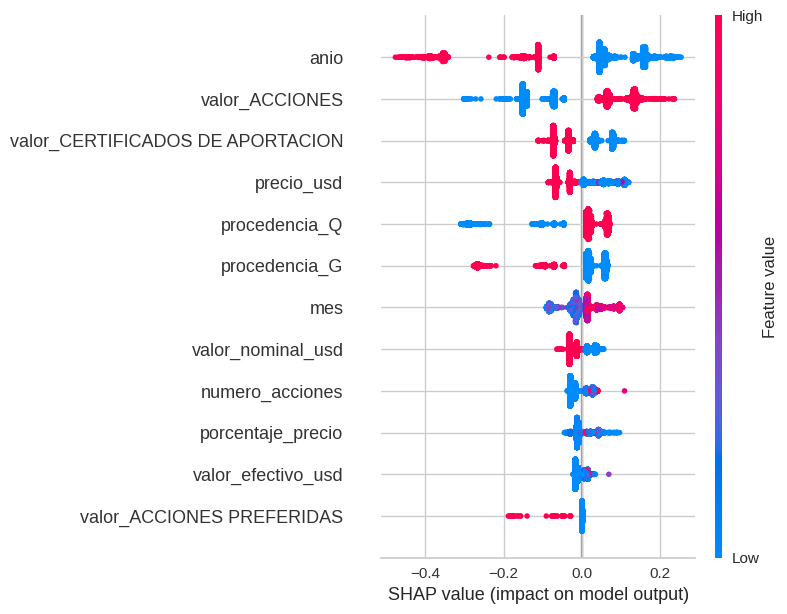

In [23]:
#  Se observa la representación del clúster 0
shap.summary_plot(shap_values[0], df_ftr)

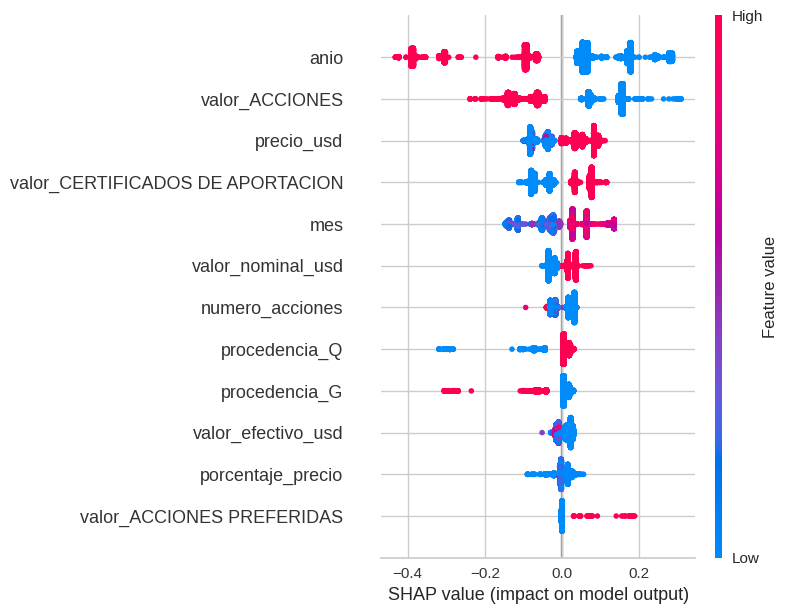

In [24]:
#  Se observan la representación del clúster 1
shap.summary_plot(shap_values[1], df_ftr)

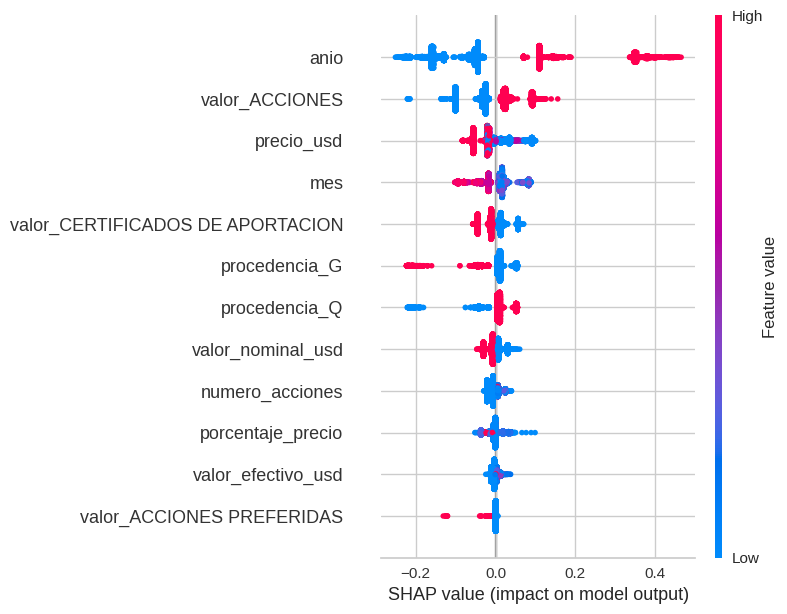

In [25]:
#  Se observan la representación del clúster 2
shap.summary_plot(shap_values[2], df_ftr)

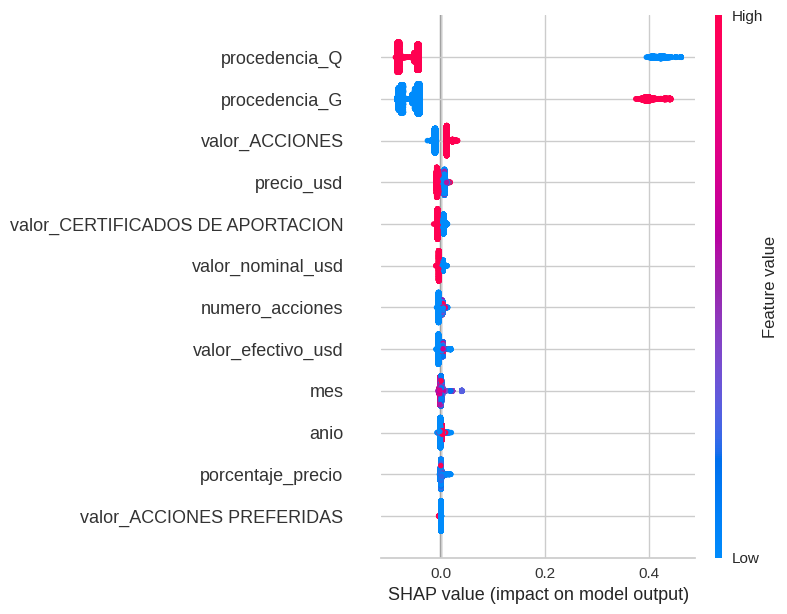

In [26]:
#  Se observan la representación del clúster 3
shap.summary_plot(shap_values[3], df_ftr)

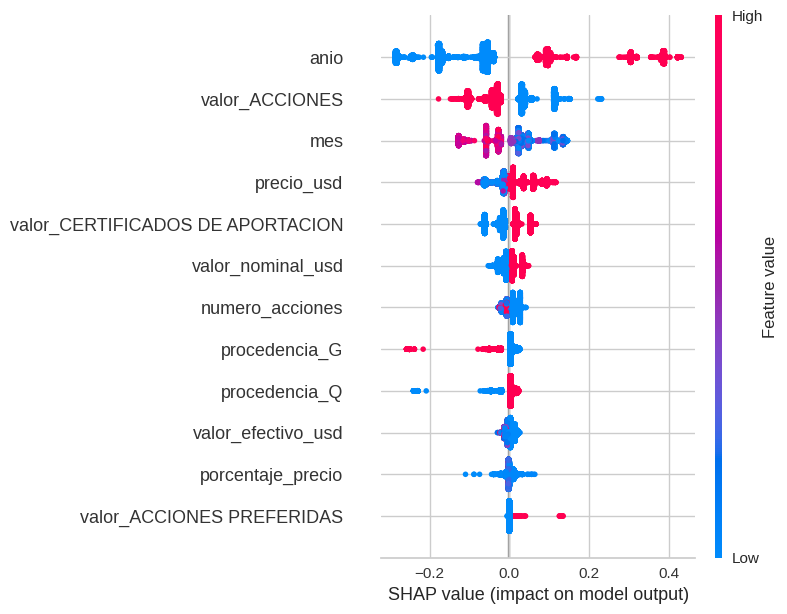

In [27]:
#  Se observan la representación del clúster 4
shap.summary_plot(shap_values[4], df_ftr)

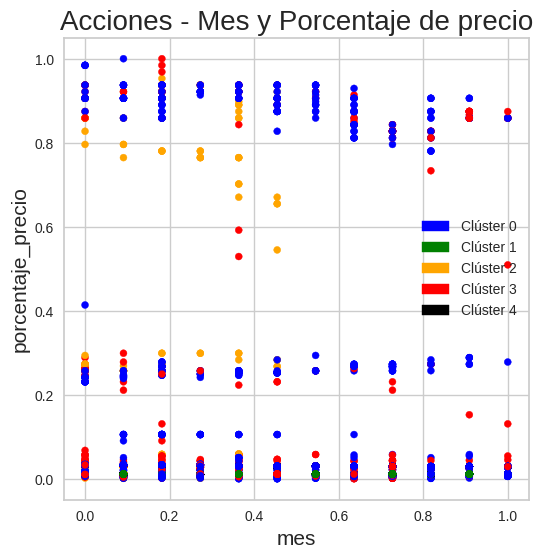

In [29]:
# Con los datos obtenidos anteriormente no se puede determinar en cuál clúster es conveniente realizar inversiones.
# Para probar con otras características, se va a analizar la relación entre los días de plazo y el porcentaje de rendimiento entre los clústeres.

# Realizar gráfico, dándole un color diferente a cada clúster para mejor apreciación.
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("mes", fontsize = 15)
ax.set_ylabel("porcentaje_precio", fontsize = 15)
ax.set_title("Acciones - Mes y Porcentaje de precio", fontsize = 20)
color = np.array(["blue", "green", "orange", "red", "black"])
ax.scatter(x = df_sc_c.mes, y = df_sc_c.porcentaje_precio, c = color[df_sc_c.cluster], s = 25)

# Crear etiquetas de la leyenda.
azul = mpatches.Patch(color = "blue", label = "Clúster 0")
verde = mpatches.Patch(color = "green", label = "Clúster 1")
naranja = mpatches.Patch(color = "orange", label = "Clúster 2")
rojo = mpatches.Patch(color = "red", label = "Clúster 3")
negro = mpatches.Patch(color = "black", label = "Clúster 4")

# Colocar la leyenda.
plt.legend(handles = [azul, verde, naranja, rojo, negro])

plt.show()

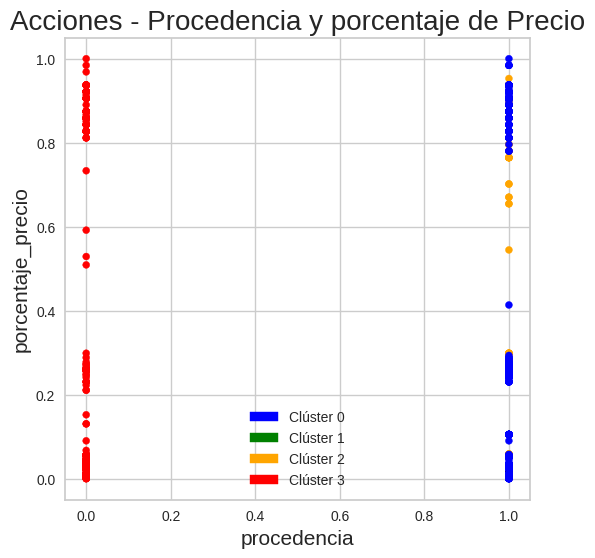

In [31]:
# Se analiza el mes de emisión y el porcentaje de rendimiento entre los clústeres.

# Realizar gráfico, dándole un color diferente a cada clúster para mejor apreciación.
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("procedencia", fontsize = 15)
ax.set_ylabel("porcentaje_precio", fontsize = 15)
ax.set_title("Acciones - Procedencia y porcentaje de Precio", fontsize = 20)
color = np.array(["blue", "green", "orange", "red", "black"])
ax.scatter(x = df_sc_c.procedencia_Q, y = df_sc_c.porcentaje_precio, c = color[df_sc_c.cluster], s = 25)

# Crear etiquetas de la leyenda.
azul = mpatches.Patch(color = "blue", label = "Clúster 0")
verde = mpatches.Patch(color = "green", label = "Clúster 1")
naranja = mpatches.Patch(color = "orange", label = "Clúster 2")
rojo = mpatches.Patch(color = "red", label = "Clúster 3")
negro = mpatches.Patch(color = "black", label = "Clúster 4")

# Colocar la leyenda.
plt.legend(handles = [azul, verde, naranja, rojo])

plt.show()

In [32]:
# Finalmente, se obtienen los listados de las empresas que corresponden a cada clúster.

# Clúster 0
sorted(df[df.cluster == 0]["emisor"].unique().tolist())

['BANCO BOLIVARIANO C.A.',
 'BANCO DE LA PRODUCCION S.A . PRODUBANCO',
 'BANCO GUAYAQUIL S.A.',
 'BANCO PICHINCHA C.A.',
 'BANCO SOLIDARIO S.A.',
 'BEVERAGE BRAND PATENTS SA',
 'BOLSA DE VALORES DE GUAYAQUIL',
 'BOLSA DE VALORES DE QUITO',
 'BRIKAPITAL SA',
 'CEPSA',
 'CERVECERIA NACIONAL CN S A',
 'CONCLINA C A  CIA CONJU CLINICO NACIONAL',
 'CONTINENTAL TIRE ANDINA S A',
 'CORPORACION FAVORITA C.A.',
 'CRIDESA',
 'HOLCIM ECUADOR S.A.',
 'HOMEFOREST EL REFUGIO FORESTAL S A',
 'HOTEL COLON',
 'INDUSTRIAS ALES',
 'INVERSANCARLOS',
 'NATLUK SA',
 'SAN CARLOS SOC. AGR. IND.',
 'SUPERDEPORTE S.A.',
 'TECAFORTUNA SA',
 'TECATEAK SA']

In [33]:
# Clúster 1
sorted(df[df.cluster == 1]["emisor"].unique().tolist())

['CONCLINA C A  CIA CONJU CLINICO NACIONAL', 'MUTUALISTA PICHINCHA']

In [34]:
# Clúster 2
sorted(df[df.cluster == 2]["emisor"].unique().tolist())

['BANCO BOLIVARIANO C.A.',
 'BANCO DE LA PRODUCCION S.A . PRODUBANCO',
 'BANCO GUAYAQUIL S.A.',
 'BANCO PICHINCHA C.A.',
 'BEVERAGE BRAND PATENTS SA',
 'BOLSA DE VALORES DE GUAYAQUIL',
 'BOLSA DE VALORES DE QUITO',
 'BRIKAPITAL SA',
 'CERVECERIA NACIONAL CN S A',
 'CONCLINA C A  CIA CONJU CLINICO NACIONAL',
 'CORPORACION FAVORITA C.A.',
 'CRIDESA',
 'HOLCIM ECUADOR S.A.',
 'HOTEL COLON',
 'INDUSTRIAS ALES',
 'INVERSANCARLOS',
 'SAN CARLOS SOC. AGR. IND.',
 'TECATEAK SA']

In [35]:
# Clúster 3
sorted(df[df.cluster == 3]["emisor"].unique().tolist())

['ALICOSTA BK HOLDING S A',
 'BANCO BOLIVARIANO C.A.',
 'BANCO DE LA PRODUCCION S.A . PRODUBANCO',
 'BANCO GUAYAQUIL S.A.',
 'BANCO PICHINCHA C.A.',
 'BEVERAGE BRAND PATENTS SA',
 'BOLSA DE VALORES DE GUAYAQUIL',
 'BOLSA DE VALORES DE QUITO',
 'BRIKAPITAL SA',
 'CERRO ALTO HIGHFOREST S A',
 'CERVECERIA NACIONAL CN S A',
 'CONTINENTAL TIRE ANDINA S A',
 'CORPORACION FAVORITA C.A.',
 'CRIDESA',
 'EL TECAL',
 'HOLCIM ECUADOR S.A.',
 'HOLDING TONICORP S.A.',
 'HOTEL COLON',
 'INDUSTRIAS ALES',
 'INVERSANCARLOS',
 'LA CUMBRE FORESTAL PEAKFOREST SA',
 'LA ENSENADA FORESTAL COVEFORESTS SA',
 'LA RESERVA FORESTAL S.A.(REFOREST)',
 'LA SABANA FORESTAL (PLAINFOREST) S.A.',
 'LA VANGUARDIA FORESTAL',
 'MERIZA',
 'MULTI-BG S.A. CORPORACION',
 'MUTUALISTA PICHINCHA',
 'RETRATOREC S.A.',
 'SAN CARLOS SOC. AGR. IND.',
 'SIEMPREVERDE SA',
 'SUPERDEPORTE S.A.',
 'TECAFORTUNA SA',
 'TECATEAK SA',
 'VALLE GRANDE FORESTAL']

In [36]:
# Clúster 4
sorted(df[df.cluster == 4]["emisor"].unique().tolist())

['CONCLINA C A  CIA CONJU CLINICO NACIONAL', 'MUTUALISTA PICHINCHA']